In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import itertools
from datetime import datetime, timedelta
import random

random.seed(42)
np.random.seed(42)

# --- Synthetic data: transactions (order_id -> list of product_ids) ---
def create_synthetic_transactions(n_products=30, n_days=60, avg_tx_per_day=80):
    products = [f"P{str(i).zfill(3)}" for i in range(1, n_products+1)]
    dates = [datetime(2025,1,1) + timedelta(days=i) for i in range(n_days)]
    transactions = []
    order_counter = 1
    for d in dates:
        for _ in range(random.randint(int(avg_tx_per_day*0.6), int(avg_tx_per_day*1.4))):
            order_id = f"O{order_counter}"
            order_counter += 1
            # sample 1-4 unique products per basket
            k = np.random.choice([1,2,3,4], p=[0.5,0.3,0.15,0.05])
            items = random.sample(products, k)
            transactions.append({"order_id": order_id, "transaction_date": d, "products": items})
    return pd.DataFrame(transactions), pd.DataFrame({"product_id": products})

tx_df, products_df = create_synthetic_transactions()
print("Transactions:", len(tx_df), "Products:", len(products_df))
tx_df.head()


Transactions: 4823 Products: 30


,order_id,transaction_date,products
0,O1,2025-01-01,[P001]
1,O2,2025-01-01,"[P024, P009, P008, P005]"
2,O3,2025-01-01,"[P024, P004]"
3,O4,2025-01-01,"[P022, P024]"
4,O5,2025-01-01,[P029]


In [24]:
# Convert transactions -> list of product lists (already 'products' column)
tx_groups = tx_df[['order_id','products']]

# Total transactions
TOTAL_TX = len(tx_groups)

# Count single-item supports (number of tx containing product)
item_counter = Counter()
for items in tx_groups['products']:
    for p in set(items):
        item_counter[p] += 1

# Count ordered pairs (A->B) occurrences (we use directed pairs for confidence)
pair_counter = Counter()
for items in tx_groups['products']:
    unique_items = sorted(set(items))
    # permutations to treat A->B and B->A separately (for confidence direction)
    for a,b in itertools.permutations(unique_items, 2):
        pair_counter[(a,b)] += 1

# Convert to DataFrame of metrics
rows = []
for (a,b), cnt in pair_counter.items():
    support_ab = cnt / TOTAL_TX
    support_a = item_counter[a] / TOTAL_TX
    support_b = item_counter[b] / TOTAL_TX
    # confidence A->B = support(A,B) / support(A)
    confidence = support_ab / support_a if support_a>0 else 0
    # lift = confidence / support(B)
    lift = confidence / support_b if support_b>0 else 0
    rows.append({"A":a,"B":b,"count":cnt,"support":support_ab,"confidence":confidence,"lift":lift})

affinity_df = pd.DataFrame(rows).sort_values(by=['lift','support'], ascending=False)
affinity_df.reset_index(drop=True, inplace=True)
affinity_df.head(10)


,A,B,count,support,confidence,lift
0,P016,P029,20,0.004147,0.071174,1.384169
1,P029,P016,20,0.004147,0.080645,1.384169
2,P001,P007,16,0.003317,0.065844,1.306847
3,P007,P001,16,0.003317,0.065844,1.306847
4,P020,P021,22,0.004561,0.081481,1.243624
5,P021,P020,22,0.004561,0.069620,1.243624
6,P007,P016,17,0.003525,0.069959,1.200753
7,P016,P007,17,0.003525,0.060498,1.200753
8,P004,P025,20,0.004147,0.071429,1.167797
9,P025,P004,20,0.004147,0.067797,1.167797


In [25]:
def top_n_affinities(df, n=10):
    # remove trivial pairs where A==B if any
    df = df[df['A'] != df['B']]
    top = df.sort_values('lift', ascending=False).head(n)
    # add readable supports as counts too
    top = top[['A','B','count','support','confidence','lift']].reset_index(drop=True)
    return top

top10 = top_n_affinities(affinity_df, 10)
print("Top 10 affinities (A -> B):")
print(top10.to_string(index=False))


Top 10 affinities (A -> B):
   A    B  count  support  confidence     lift
P016 P029     20 0.004147    0.071174 1.384169
P029 P016     20 0.004147    0.080645 1.384169
P001 P007     16 0.003317    0.065844 1.306847
P007 P001     16 0.003317    0.065844 1.306847
P020 P021     22 0.004561    0.081481 1.243624
P021 P020     22 0.004561    0.069620 1.243624
P007 P016     17 0.003525    0.069959 1.200753
P016 P007     17 0.003525    0.060498 1.200753
P004 P025     20 0.004147    0.071429 1.167797
P025 P004     20 0.004147    0.067797 1.167797


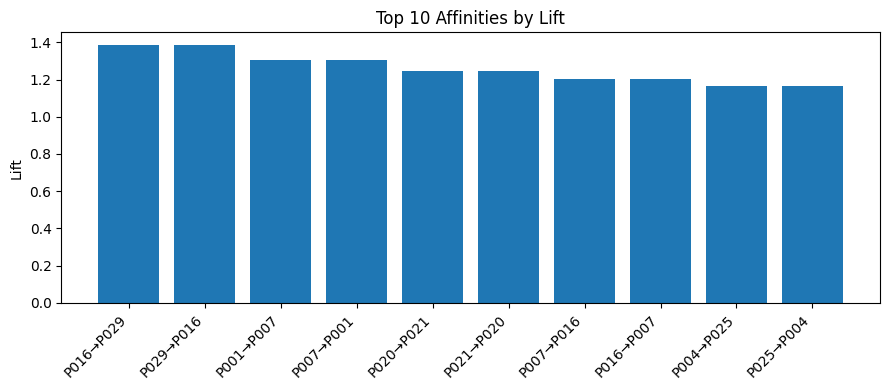

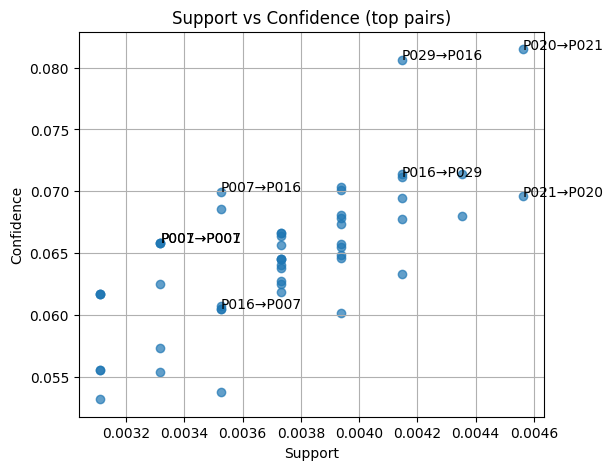

In [26]:
# Bar chart of top-10 lifts
plt.figure(figsize=(9,4))
plt.bar(range(len(top10)), top10['lift'])
plt.xticks(range(len(top10)), [f"{r['A']}→{r['B']}" for _,r in top10.iterrows()], rotation=45, ha='right')
plt.ylabel('Lift'); plt.title('Top 10 Affinities by Lift'); plt.tight_layout()
plt.show()

# Scatter: support vs confidence for top 50 pairs
sample = affinity_df.sort_values('lift', ascending=False).head(50)
plt.figure(figsize=(6,5))
plt.scatter(sample['support'], sample['confidence'], alpha=0.7)
for i,row in sample.head(8).iterrows():
    plt.annotate(f"{row['A']}→{row['B']}", (row['support'],row['confidence']))
plt.xlabel('Support'); plt.ylabel('Confidence'); plt.title('Support vs Confidence (top pairs)')
plt.grid(True); plt.show()


In [27]:
def compute_affinity_metrics(transactions):
    """
    transactions: iterable of lists of product_ids (one list per tx)
    returns: DataFrame with columns A,B,count,support,confidence,lift
    """
    tx_list = list(transactions)
    T = len(tx_list)
    item_cnt = Counter()
    pair_cnt = Counter()
    for items in tx_list:
        uniq = set(items)
        for p in uniq:
            item_cnt[p] += 1
        for a,b in itertools.permutations(sorted(uniq), 2):
            pair_cnt[(a,b)] += 1
    rows=[]
    for (a,b),cnt in pair_cnt.items():
        support_ab = cnt / T
        support_a = item_cnt[a] / T
        support_b = item_cnt[b] / T
        conf = support_ab / support_a if support_a>0 else 0
        lift = conf / support_b if support_b>0 else 0
        rows.append({"A":a,"B":b,"count":cnt,"support":support_ab,"confidence":conf,"lift":lift})
    return pd.DataFrame(rows).sort_values(['lift','support'], ascending=False).reset_index(drop=True)

# Example usage:
aff_df2 = compute_affinity_metrics(tx_df['products'])
print("Pairs computed:", len(aff_df2))
aff_df2.head()


Pairs computed: 870


,A,B,count,support,confidence,lift
0,P016,P029,20,0.004147,0.071174,1.384169
1,P029,P016,20,0.004147,0.080645,1.384169
2,P001,P007,16,0.003317,0.065844,1.306847
3,P007,P001,16,0.003317,0.065844,1.306847
4,P020,P021,22,0.004561,0.081481,1.243624


In [28]:
# Start with existing counters (from step 2)
item_counter = Counter()
pair_counter = Counter()
TOTAL_TX = 0

def init_counters(transactions):
    global item_counter, pair_counter, TOTAL_TX
    item_counter = Counter()
    pair_counter = Counter()
    TOTAL_TX = 0
    for items in transactions:
        TOTAL_TX += 1
        uniq = set(items)
        for p in uniq:
            item_counter[p] += 1
        for a,b in itertools.permutations(sorted(uniq), 2):
            pair_counter[(a,b)] += 1

def incremental_add(new_transactions):
    """
    new_transactions: list of lists of product ids
    Updates counters in place and returns None.
    """
    global item_counter, pair_counter, TOTAL_TX
    for items in new_transactions:
        TOTAL_TX += 1
        uniq = set(items)
        for p in uniq:
            item_counter[p] += 1
        for a,b in itertools.permutations(sorted(uniq), 2):
            pair_counter[(a,b)] += 1

def get_metrics_from_counters(top_k=20):
    rows=[]
    for (a,b), cnt in pair_counter.items():
        support_ab = cnt / TOTAL_TX
        support_a = item_counter[a] / TOTAL_TX
        support_b = item_counter[b] / TOTAL_TX
        confidence = support_ab / support_a if support_a>0 else 0
        lift = confidence / support_b if support_b>0 else 0
        rows.append({"A":a,"B":b,"count":cnt,"support":support_ab,"confidence":confidence,"lift":lift})
    df = pd.DataFrame(rows).sort_values(['lift','support'], ascending=False).reset_index(drop=True)
    return df.head(top_k)

# Initialize counters with existing transactions
init_counters(tx_df['products'])

# Simulate new incoming transactions:
new_tx = [["P001","P005"], ["P003","P020","P005"], ["P005"]]
incremental_add(new_tx)

# Get top affinities after increment
print(get_metrics_from_counters(10))


      A     B  count   support  confidence      lift
0  P016  P029     20  0.004144    0.071174  1.385030
1  P029  P016     20  0.004144    0.080645  1.385030
2  P007  P001     16  0.003315    0.065844  1.302300
3  P001  P007     16  0.003315    0.065574  1.302300
4  P020  P021     22  0.004559    0.081181  1.239806
5  P021  P020     22  0.004559    0.069620  1.239806
6  P007  P016     17  0.003523    0.069959  1.201500
7  P016  P007     17  0.003523    0.060498  1.201500
8  P025  P004     20  0.004144    0.067797  1.168523
9  P004  P025     20  0.004144    0.071429  1.168523


In [29]:
# Save top N to CSV (for dashboard ingestion)
top_affs = top_n_affinities(affinity_df, n=100)
top_affs.to_csv("/mnt/data/top_affinities.csv", index=False)
print("Saved /mnt/data/top_affinities.csv")


Saved /mnt/data/top_affinities.csv


Total restock events: 100
Clean restock events after validation: 73
Quarantined records: 6
Reconciliation complete. Files saved under /mnt/data


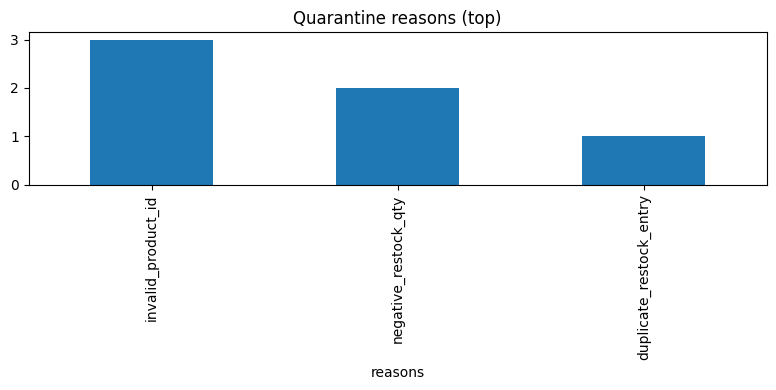

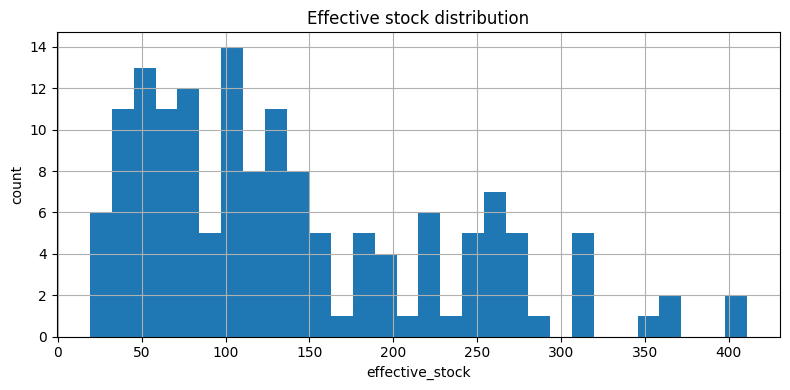

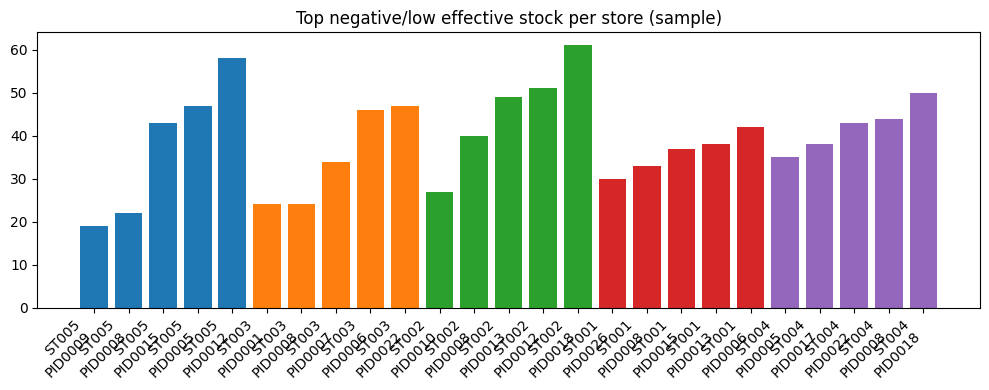


Suggested fuzzy matches (top 20):
 quarantine_index store_id original_product_id original_product_name suggested_product_id suggested_product_name    score
             35.0    ST002         UNKNOWN_740       UnknownItem_185              PID0015         BrandZ_Item_15 0.551724
             35.0    ST002         UNKNOWN_740       UnknownItem_185              PID0018         BrandX_Item_18 0.551724
             89.0    ST005         UNKNOWN_637       UnknownItem_145              PID0015         BrandZ_Item_15 0.551724
             89.0    ST005         UNKNOWN_637       UnknownItem_145              PID0014         BrandX_Item_14 0.551724
             41.0    ST003         UNKNOWN_952        UnknownItem_93              PID0009          BrandZ_Item_9 0.518519
             41.0    ST003         UNKNOWN_952        UnknownItem_93              PID0003          BrandX_Item_3 0.518519
             35.0    ST002         UNKNOWN_740       UnknownItem_185              PID0001          BrandZ_Item_

In [30]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import os
from difflib import SequenceMatcher, get_close_matches
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)
os.makedirs('/mnt/data', exist_ok=True)

n_products = 30
products = pd.DataFrame({
    'product_id': [f'PID{str(i).zfill(4)}' for i in range(1, n_products+1)],
    'product_name': [f'Brand{random.choice(["X","Y","Z"])}_Item_{i}' for i in range(1, n_products+1)],
    'sku': [f'SKU{1000+i}' for i in range(n_products)],
    'logical_max': np.random.randint(50, 500, n_products)
})

stores = [f'ST{str(i).zfill(3)}' for i in range(1,6)]
snapshot_rows = []
snapshot_date = datetime(2025,6,15)
for store in stores:
    for _, row in products.iterrows():
        lvl = max(0, int(row['logical_max'] * np.random.uniform(0.1, 0.9)))
        snapshot_rows.append({
            'store_id': store,
            'snapshot_date': snapshot_date,
            'product_id': row['product_id'],
            'product_name': row['product_name'],
            'sku': row['sku'],
            'snapshot_level': lvl
        })
store_inventory_snapshot = pd.DataFrame(snapshot_rows)

restock_rows = []
for store in stores:
    for i in range(20):
        r = random.random()
        if r < 0.05:
            product_id = 'UNKNOWN_' + str(random.randint(1,999))
            product_name = f'UnknownItem_{random.randint(1,200)}'
            sku = ''
        elif r < 0.10:
            p = products.sample(1).iloc[0]
            product_id = p['product_id']; product_name = p['product_name']; sku = p['sku']
        else:
            p = products.sample(1).iloc[0]
            product_id = p['product_id']; product_name = p['product_name']; sku = p['sku']
        qty = int(np.random.choice([1,2,5,10,20,50], p=[0.4,0.25,0.15,0.1,0.06,0.04]))
        if random.random() < 0.02:
            qty = -abs(qty)
        restock_rows.append({
            'store_id': store,
            'restock_date': snapshot_date + timedelta(days=random.randint(0,2)),
            'product_id': product_id,
            'product_name': product_name,
            'sku': sku,
            'restock_qty': qty,
            'restock_id': f'R{store}_{i}'
        })
restock_events = pd.DataFrame(restock_rows)

damaged_rows = []
for store in stores:
    for _, prod in products.sample(10).iterrows():
        damaged_rows.append({
            'store_id': store,
            'product_id': prod['product_id'],
            'damaged_qty': int(np.random.choice([0,0,1,2,5], p=[0.6,0.2,0.1,0.07,0.03]))
        })
damaged_df = pd.DataFrame(damaged_rows)

store_inventory_snapshot.to_csv('/mnt/data/store_inventory_snapshot.csv', index=False)
restock_events.to_csv('/mnt/data/restock_events.csv', index=False)
products.to_csv('/mnt/data/products_master.csv', index=False)
damaged_df.to_csv('/mnt/data/damaged.csv', index=False)

default_config = {
    'snapshot': {'path': '/mnt/data/store_inventory_snapshot.csv', 'mappings': {'store_id': 'store_id','snapshot_date': 'snapshot_date','product_id': 'product_id','product_name': 'product_name','sku': 'sku','snapshot_level': 'snapshot_level'}},
    'restock': {'path': '/mnt/data/restock_events.csv', 'mappings': {'store_id': 'store_id','restock_date': 'restock_date','product_id': 'product_id','product_name': 'product_name','sku': 'sku','restock_qty': 'restock_qty','restock_id': 'restock_id'}},
    'products_master': {'path': '/mnt/data/products_master.csv', 'mappings': {'product_id': 'product_id','product_name': 'product_name','sku': 'sku','logical_max': 'logical_max'}},
    'damaged': {'path': '/mnt/data/damaged.csv', 'mappings': {'store_id': 'store_id','product_id': 'product_id','damaged_qty': 'damaged_qty'}}
}

def load_csv_config(cfg_section):
    path = cfg_section['path']; mappings = cfg_section['mappings']
    df = pd.read_csv(path)
    rename_map = {v:k for k,v in mappings.items()}
    df = df.rename(columns=rename_map)
    return df

snapshot_df = load_csv_config(default_config['snapshot'])
restock_df = load_csv_config(default_config['restock'])
products_master = load_csv_config(default_config['products_master'])
damaged = load_csv_config(default_config['damaged'])
snapshot_df['snapshot_date'] = pd.to_datetime(snapshot_df['snapshot_date'])
restock_df['restock_date'] = pd.to_datetime(restock_df['restock_date'])

quarantine_rows = []; clean_restock_rows = []
valid_product_ids = set(products_master['product_id'].tolist())
logical_max_map = dict(zip(products_master['product_id'], products_master['logical_max']))

for idx, r in restock_df.iterrows():
    rec = r.to_dict(); rec['__row_index'] = idx; reasons = []
    if pd.isna(rec.get('restock_qty')):
        reasons.append('restock_qty_missing')
    else:
        if rec['restock_qty'] < 0:
            reasons.append('negative_restock_qty')
    pid = rec.get('product_id')
    if pid not in valid_product_ids:
        reasons.append('invalid_product_id')
    if pid in logical_max_map and not pd.isna(rec.get('restock_qty')):
        if abs(rec['restock_qty']) > logical_max_map[pid] * 2:
            reasons.append('restock_qty_exceeds_logical_max')
    if reasons:
        rec['reasons'] = ';'.join(reasons); quarantine_rows.append(rec)
    else:
        clean_restock_rows.append(rec)

clean_restock_df = pd.DataFrame(clean_restock_rows)
quarantine_df = pd.DataFrame(quarantine_rows)

dup_mask = restock_df.duplicated(subset=['store_id','restock_date','product_id'], keep=False)
dups = restock_df[dup_mask]
if not dups.empty:
    for idx,r in dups.iterrows():
        row = r.to_dict(); row['reasons']='duplicate_restock_entry'
        quarantine_df = pd.concat([quarantine_df, pd.DataFrame([row])], ignore_index=True)
    if not clean_restock_df.empty:
        dup_set = set([(d['store_id'], d['restock_date'], d['product_id']) for _,d in dups.iterrows()])
        clean_restock_df = clean_restock_df[~clean_restock_df.apply(lambda x: ((x['store_id'], x['restock_date'], x['product_id']) in dup_set), axis=1)]

quarantine_df = quarantine_df.drop_duplicates(subset=['__row_index']) if not quarantine_df.empty else quarantine_df

if not clean_restock_df.empty:
    restock_agg = clean_restock_df.groupby(['store_id','product_id']).agg(incoming_restock_qty=('restock_qty','sum')).reset_index()
else:
    restock_agg = pd.DataFrame(columns=['store_id','product_id','incoming_restock_qty'])

snap = snapshot_df[['store_id','product_id','snapshot_level']].copy()
recon = snap.merge(restock_agg, on=['store_id','product_id'], how='left')
recon = recon.merge(damaged[['store_id','product_id','damaged_qty']], on=['store_id','product_id'], how='left')
recon['incoming_restock_qty'] = recon['incoming_restock_qty'].fillna(0)
recon['damaged_qty'] = recon['damaged_qty'].fillna(0)
recon['effective_stock'] = recon['snapshot_level'] + recon['incoming_restock_qty'] - recon['damaged_qty']

neg_mask = recon['effective_stock'] < 0
neg_records = recon[neg_mask]
if not neg_records.empty:
    for _,r in neg_records.iterrows():
        quarantine_df = pd.concat([quarantine_df, pd.DataFrame([{'__row_index': f'recon_{r.store_id}_{r.product_id}','store_id': r.store_id,'product_id': r.product_id,'reasons': 'effective_stock_negative'}])], ignore_index=True)
    recon = recon[~neg_mask]

recon = recon.merge(products_master[['product_id','product_name']], on='product_id', how='left')

master_names = products_master['product_name'].tolist()
master_pid_by_name = dict(zip(products_master['product_name'], products_master['product_id']))

if not quarantine_df.empty:
    quarantine_df = quarantine_df.fillna('')
    suggestions = []
    for idx, q in quarantine_df.iterrows():
        reasons = q.get('reasons','')
        if 'invalid_product_id' in reasons and q.get('product_name')!='':
            name = q['product_name']
            matches = get_close_matches(name, master_names, n=3, cutoff=0.5)
            scored = []
            for m in matches:
                score = SequenceMatcher(None, name, m).ratio()
                scored.append((m, score, master_pid_by_name[m]))
            if not scored:
                for m in master_names:
                    score = SequenceMatcher(None, name, m).ratio()
                    if score>0.45:
                        scored.append((m, score, master_pid_by_name[m]))
            scored = sorted(scored, key=lambda x: x[1], reverse=True)[:3]
            for m,score,pid in scored:
                suggestions.append({
                    'quarantine_index': q.get('__row_index',''),
                    'store_id': q.get('store_id',''),
                    'original_product_id': q.get('product_id',''),
                    'original_product_name': name,
                    'suggested_product_id': pid,
                    'suggested_product_name': m,
                    'score': float(score)
                })
    suggestions_df = pd.DataFrame(suggestions)
else:
    suggestions_df = pd.DataFrame()

recon_out = recon[['store_id','product_id','product_name','snapshot_level','incoming_restock_qty','damaged_qty','effective_stock']].copy()
recon_out.to_csv('/mnt/data/cleaned_inventory.csv', index=False)
quarantine_df.to_csv('/mnt/data/quarantine_inventory.csv', index=False)
suggestions_df.to_csv('/mnt/data/recommended_matches.csv', index=False)

print('Total restock events:', len(restock_df))
print('Clean restock events after validation:', len(clean_restock_df))
print('Quarantined records:', len(quarantine_df))
print('Reconciliation complete. Files saved under /mnt/data')

plt.figure(figsize=(8,4))
if not quarantine_df.empty:
    reasons_series = quarantine_df['reasons'].str.split(';').explode()
    reasons_counts = reasons_series.value_counts().head(15)
    reasons_counts.plot(kind='bar')
    plt.title('Quarantine reasons (top)')
    plt.tight_layout()
    plt.show()
else:
    print('No quarantined rows to plot')

plt.figure(figsize=(8,4))
recon_out['effective_stock'].hist(bins=30)
plt.title('Effective stock distribution')
plt.xlabel('effective_stock')
plt.ylabel('count')
plt.tight_layout()
plt.show()

top_shortage = recon_out.sort_values('effective_stock').groupby('store_id').head(5)
if not top_shortage.empty:
    plt.figure(figsize=(10,4))
    for store in top_shortage['store_id'].unique():
        sub = top_shortage[top_shortage['store_id']==store]
        plt.bar([f"{store}\n{p}" for p in sub['product_id']], sub['effective_stock'])
    plt.title('Top negative/low effective stock per store (sample)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

if not suggestions_df.empty:
    display_limit = suggestions_df.sort_values('score', ascending=False).head(20)
    print('\nSuggested fuzzy matches (top 20):')
    print(display_limit.to_string(index=False))
